# Part 1: Initialize your workspace

## Step 1
Upload the CMPT733-Lab2-Workspace folder to your Google drive

## Step **2**
Mount your Google drive using the following code

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Step 3
Change directory to allow imports

In [2]:
import os
os.chdir("/content/gdrive/MyDrive/CMPT733-Lab2-Workspace")

## Step 4
Download and extract the kings college dataset in the data folder. Give about 5 to 10 minutes to it to download and extract the files.

In [3]:
![ ! -d "data" ] && wget -nc https://www.repository.cam.ac.uk/bitstream/handle/1810/251342/KingsCollege.zip
![ ! -d "data" ] && mkdir data && unzip -qq KingsCollege.zip -d "data/" && rm KingsCollege.zip
![ ! -d "checkpoints" ] && mkdir "checkpoints/"
!echo "done!"

done!


## Step 5
Check if everything is correct. You should find two folders (data and pretrained_models) here.

In [4]:
!ls

checkpoints  data  pretrained_models


# Part 2: Inception Block

In [5]:
from torch.nn.modules import padding
from torch.nn.modules.batchnorm import BatchNorm2d
import torch
import torch.nn as nn
import torch.nn.functional as F

import pickle


def init(key, module, weights=None):
    if weights == None:
        return module

    # initialize bias.data: layer_name_1 in weights
    # initialize  weight.data: layer_name_0 in weights
    module.bias.data = torch.from_numpy(weights[(key + "_1").encode()])
    module.weight.data = torch.from_numpy(weights[(key + "_0").encode()])

    return module


class InceptionBlock(nn.Module):
    def __init__(self, in_channels, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes, key=None, weights=None):
        super(InceptionBlock, self).__init__()

        # TODO: Implement InceptionBlock
        # Use 'key' to load the pretrained weights for the correct InceptionBlock
        keyName_1 = 'inception_{name1}/{name2}'.format(name1=key, name2='1x1')
        keyName_2 = 'inception_{name1}/{name2}'.format(name1=key, name2='3x3_reduce')
        keyName_3 = 'inception_{name1}/{name2}'.format(name1=key, name2='3x3')
        keyName_4 = 'inception_{name1}/{name2}'.format(name1=key, name2='5x5_reduce')
        keyName_5 = 'inception_{name1}/{name2}'.format(name1=key, name2='5x5')
        keyName_6 = 'inception_{name1}/{name2}'.format(name1=key, name2='pool_proj')

        # 1x1 conv branch
        self.b1 = nn.Sequential(
          init(keyName_1, nn.Conv2d(in_channels, n1x1, kernel_size=1), weights),
          nn.ReLU(True)
        )

        # 1x1 -> 3x3 conv branch
        self.b2 = nn.Sequential(
          init(keyName_2, nn.Conv2d(in_channels, n3x3red, kernel_size=1), weights),
          nn.ReLU(True),
          init(keyName_3, nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1), weights),
          nn.ReLU(True)
        )

        # 1x1 -> 5x5 conv branch
        self.b3 = nn.Sequential(
          init(keyName_4, nn.Conv2d(in_channels, n5x5red, kernel_size=1), weights),
          nn.ReLU(True),
          init(keyName_5, nn.Conv2d(n5x5red, n5x5, kernel_size=5, padding=2), weights),
          nn.ReLU(True)
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
          nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
          nn.ReLU(True),
          init(keyName_6, nn.Conv2d(in_channels, pool_planes, kernel_size=1), weights),
          nn.ReLU(True)
        )

    def forward(self, x):
        # TODO: Feed data through branches and concatenate
        br1 = self.b1(x)
        br2 = self.b2(x)
        br3 = self.b3(x)
        br4 = self.b4(x)

        y = torch.cat([br1, br2, br3, br4], 1)
        return y

# Part 3: PoseNet Architecture

In [6]:
class LossHeader(nn.Module):
    def __init__(self, key, weights=None, channel=512, in_channels=2048, out_channels=1024, p_value=0.7):
        super(LossHeader, self).__init__()

        keyName_1 = '{name1}/{name2}'.format(name1=key, name2='conv')
        keyName_2 = '{name1}/{name2}'.format(name1=key, name2='fc')
        keyName_3 = '{name1}/{name2}'.format(name1=key, name2='classifier')

        self.loss_header_1 = None
        self.loss_header_2 = None
        # TODO: Define loss headers
        if key == "loss3":
          self.loss_header_1 = nn.Sequential(
              nn.AvgPool2d(kernel_size=7, stride=1),
              nn.ReLU(True),
              nn.Flatten(),
              nn.Linear(in_channels, out_channels),
              nn.Dropout(p=p_value),
              nn.Linear(out_channels, 3)
          )
        else:
          self.loss_header_1 = nn.Sequential(
              nn.AvgPool2d(kernel_size=5, stride=3),
              nn.ReLU(True),
              init(keyName_1, nn.Conv2d(channel, 128, kernel_size=1), weights),
              nn.ReLU(True),
              nn.Flatten(),
              init(keyName_2, nn.Linear(in_channels, out_channels), weights),
              nn.Dropout(p=p_value),
              nn.Linear(out_channels, 3)
          )
        
        if key == "loss3":
          self.loss_header_2 = nn.Sequential(
              nn.AvgPool2d(kernel_size=7, stride=1),
              nn.ReLU(True),
              nn.Flatten(),
              nn.Linear(in_channels, out_channels),
              nn.Dropout(p=p_value),
              nn.Linear(out_channels, 4)
          )
        else:
          self.loss_header_2 = nn.Sequential(
              nn.AvgPool2d(kernel_size=5, stride=3),
              nn.ReLU(True),
              init(keyName_1, nn.Conv2d(channel, 128, kernel_size=1, stride=1), weights),
              nn.ReLU(True),
              nn.Flatten(),
              init(keyName_2, nn.Linear(in_channels, out_channels), weights),
              nn.Dropout(p=p_value),
              nn.Linear(out_channels, 4)
          )

    def forward(self, x):
        # TODO: Feed data through loss headers
        xyz = self.loss_header_1(x)
        wpqr = self.loss_header_2(x)

        return xyz, wpqr


class PoseNet(nn.Module):
    def __init__(self, load_weights=True):
        super(PoseNet, self).__init__()

        # Load pretrained weights file
        if load_weights:
            print("Loading pretrained InceptionV1 weights...")
            file = open('pretrained_models/places-googlenet.pickle', "rb")
            weights = pickle.load(file, encoding="bytes")
            file.close()
        # Ignore pretrained weights
        else:
            weights = None

        # TODO: Define PoseNet layers

        # self.pre_layers = nn.Sequential(
        #     # Example for defining a layer and initializing it with pretrained weights
        #     init('conv1/7x7_s2', nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3), weights),

        # )
        self.pre_layers = nn.Sequential(
            init('conv1/7x7_s2', nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3), weights),
            nn.ReLU(True),
            nn.MaxPool2d(3, stride=2, padding=1),
            # nn.ReLU(True),
            nn.LocalResponseNorm(size=5),
            init('conv2/3x3_reduce', nn.Conv2d(64, 64, kernel_size=1), weights),
            nn.ReLU(True),
            init('conv2/3x3', nn.Conv2d(64, 192, kernel_size=3, padding=1), weights),
            nn.ReLU(True),
            nn.LocalResponseNorm(size=5),
            nn.MaxPool2d(3, stride=2, padding=1),
            # nn.ReLU(True)
        )

        # Example for InceptionBlock initialization
        # self._3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32, "3a", weights)
        self._3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32, "3a", weights)
        self._3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64, "3b", weights)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=1)
        self.relu = nn.ReLU()
        self._4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64, "4a", weights)
        self._4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64, "4b", weights)
        self._4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64, "4c", weights)
        self._4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64, "4d", weights)
        self._4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128, "4e", weights)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, padding=1)
        self._5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128, "5a", weights)
        self._5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128, "5b", weights)

        self.loss_header_1 = LossHeader("loss1", weights, channel=512, in_channels=2048, out_channels=1024, p_value=0.7)
        self.loss_header_2 = LossHeader("loss2", weights, channel=528, in_channels=2048, out_channels=1024, p_value=0.7)
        self.loss_header_3 = LossHeader("loss3", weights, channel=0, in_channels=1024, out_channels=2048, p_value=0.4)

        print("PoseNet model created!")

    def forward(self, x):
        # TODO: Implement PoseNet forward
        x = self.pre_layers(x)

        x = self._3a(x)
        x = self._3b(x)
        x = self.maxpool3(x)
        # x = self.relu(x)
        x = self._4a(x)
        loss1_xyz, loss1_wpqr = self.loss_header_1(x)

        x = self._4b(x)
        x = self._4c(x)
        x = self._4d(x)
        loss2_xyz, loss2_wpqr = self.loss_header_2(x)

        x = self._4e(x)
        x = self.maxpool4(x)
        # x = self.relu(x)
        x = self._5a(x)
        x = self._5b(x)

        loss3_xyz, loss3_wpqr = self.loss_header_3(x)

        if self.training:
            return loss1_xyz, \
                   loss1_wpqr, \
                   loss2_xyz, \
                   loss2_wpqr, \
                   loss3_xyz, \
                   loss3_wpqr
        else:
            return loss3_xyz, \
                   loss3_wpqr




In [ ]:
import pickle
print("Loading pretrained InceptionV1 weights...")
file = open('pretrained_models/places-googlenet.pickle', "rb")
weights = pickle.load(file, encoding="bytes")
print(weights.keys())
file.close()

Loading pretrained InceptionV1 weights...
odict_keys([b'conv1/7x7_s2_0', b'conv1/7x7_s2_1', b'conv2/3x3_reduce_0', b'conv2/3x3_reduce_1', b'conv2/3x3_0', b'conv2/3x3_1', b'inception_3a/1x1_0', b'inception_3a/1x1_1', b'inception_3a/3x3_reduce_0', b'inception_3a/3x3_reduce_1', b'inception_3a/3x3_0', b'inception_3a/3x3_1', b'inception_3a/5x5_reduce_0', b'inception_3a/5x5_reduce_1', b'inception_3a/5x5_0', b'inception_3a/5x5_1', b'inception_3a/pool_proj_0', b'inception_3a/pool_proj_1', b'inception_3b/1x1_0', b'inception_3b/1x1_1', b'inception_3b/3x3_reduce_0', b'inception_3b/3x3_reduce_1', b'inception_3b/3x3_0', b'inception_3b/3x3_1', b'inception_3b/5x5_reduce_0', b'inception_3b/5x5_reduce_1', b'inception_3b/5x5_0', b'inception_3b/5x5_1', b'inception_3b/pool_proj_0', b'inception_3b/pool_proj_1', b'inception_4a/1x1_0', b'inception_4a/1x1_1', b'inception_4a/3x3_reduce_0', b'inception_4a/3x3_reduce_1', b'inception_4a/3x3_0', b'inception_4a/3x3_1', b'inception_4a/5x5_reduce_0', b'inception_4a/5

# Part 4: Loss Function

In [7]:
class PoseLoss(nn.Module):

    def __init__(self, w1_xyz, w2_xyz, w3_xyz, w1_wpqr, w2_wpqr, w3_wpqr):
        super(PoseLoss, self).__init__()

        self.w1_xyz = w1_xyz
        self.w2_xyz = w2_xyz
        self.w3_xyz = w3_xyz
        self.w1_wpqr = w1_wpqr
        self.w2_wpqr = w2_wpqr
        self.w3_wpqr = w3_wpqr


    def forward(self, p1_xyz, p1_wpqr, p2_xyz, p2_wpqr, p3_xyz, p3_wpqr, poseGT):
        # TODO: Implement loss
        # First 3 entries of poseGT are ground truth xyz, last 4 values are ground truth wpqr
        gt_norm = torch.norm(poseGT[:, 3:], dim=1)
        pose_norm = torch.div(torch.t(poseGT[:, 3:]), gt_norm)
        pose_norm = torch.t(pose_norm)
        
        mseLoss = nn.MSELoss()
        loss1 = mseLoss(p1_xyz, poseGT[:, :3]) + self.w1_wpqr * mseLoss(p1_wpqr, pose_norm)
        loss2 = mseLoss(p2_xyz, poseGT[:, :3]) + self.w2_wpqr * mseLoss(p2_wpqr, pose_norm)
        loss3 = mseLoss(p3_xyz, poseGT[:, :3]) + self.w3_wpqr * mseLoss(p3_wpqr, pose_norm)
        
        loss = self.w1_xyz * loss1 + self.w2_xyz * loss2 + self.w3_xyz * loss3
        return loss


# Part 5: DataLoader

In [21]:
import os
import torch.utils.data as data
from torchvision import transforms as T
from PIL import Image
import numpy as np

class DataSource(data.Dataset):
    def __init__(self, root, resize=256, crop_size=224, train=True):
        self.root = os.path.expanduser(root)
        self.resize = resize
        self.crop_size = crop_size
        self.train = train

        self.image_poses = []
        self.images_path = []

        self._get_data()

        # TODO: Define preprocessing
        normalize = T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        if train:
          self.transforms = T.Compose([
              # T.Resize((256, 455)),
              T.RandomCrop((224, 224)),
              T.ToTensor(),
              normalize
          ])
        else:
          self.transforms = T.Compose([
              # T.Resize((256, 455)),
              T.CenterCrop((224, 224)),
              T.ToTensor(),
              normalize
          ])


        # Load mean image
        self.mean_image_path = os.path.join(self.root, 'mean_image.npy')
        if os.path.exists(self.mean_image_path):
            self.mean_image = np.load(self.mean_image_path)
            print("Mean image loaded!")
        else:
            self.mean_image = self.generate_mean_image()

    def _get_data(self):

        if self.train:
            txt_file = self.root + 'dataset_train.txt'
        else:
            txt_file = self.root + 'dataset_test.txt'

        with open(txt_file, 'r') as f:
            next(f)  # skip the 3 header lines
            next(f)
            next(f)
            for line in f:
                fname, p0, p1, p2, p3, p4, p5, p6 = line.split()
                p0 = float(p0) / 100
                p1 = float(p1) / 100
                p2 = float(p2) / 100
                p3 = float(p3)
                p4 = float(p4)
                p5 = float(p5)
                p6 = float(p6)
                self.image_poses.append((p0, p1, p2, p3, p4, p5, p6))
                self.images_path.append(self.root + fname)

    def generate_mean_image(self):
        print("Computing mean image:")

        # TODO: Compute mean image

        # Initialize mean_image
        mean_image = np.zeros([256, 455, 3], dtype=np.float64)
        # Iterate over all training images
        # Resize, Compute mean, etc...
        for image_path in self.images_path:
          image = Image.open(image_path)
          image = image.resize((455, 256))
          # print(image.size)
          image = np.array(image, dtype=np.float64)
          # print(image.shape)
          mean_image = image + mean_image
        length = len(self.images_path)
        mean_image = mean_image / length
        # print(mean_image.shape)
        path = os.path.join(self.root, 'mean_image.npy')
        # Store mean image
        np.save(path, mean_image)
        print("Mean image computed!")

        return mean_image

    def __getitem__(self, index):
        """
        return the data of one image
        """
        img_path = self.images_path[index]
        img_pose = self.image_poses[index]

        data = Image.open(img_path)
       
        data = data.resize((455, 256))
        # TODO: Perform preprocessing
        data = np.array(data, dtype=np.float64)
        # print(data.shape)
        data_copy = data.copy()
        
        data_copy = data_copy - self.mean_image
        data_copy = Image.fromarray(np.uint8(data_copy), mode='RGB')

        data_copy = self.transforms(data_copy)
        # print(data_copy.shape)
        return data_copy, img_pose

    def __len__(self):
        return len(self.images_path)

# Part 6: Experiments

## Step 1: Training

In [22]:
import torch
import numpy as np
import torch.utils.data as Data
import torch.nn as nn
from torch.autograd import Variable
# from models.PoseNet import PoseNet, PoseLoss
# from data.DataSource import *
from torch.utils.data import Dataset, DataLoader
# import PoseNet, PoseLoss
import matplotlib.pyplot as plt
import os

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train(epochs, batch_size, learning_rate, save_freq, data_dir):
    # train dataset and train loader
    datasource = DataSource(data_dir, train=True)
    train_loader = DataLoader(dataset=datasource, batch_size=batch_size, shuffle=True)

    # load model
    posenet = PoseNet().to(device)

    # loss function
    criterion = PoseLoss(0.3, 0.3, 1., 300, 300, 300)

    # train the network
    optimizer = torch.optim.Adam(nn.ParameterList(posenet.parameters()),
                     lr=learning_rate, eps=1,
                     weight_decay=0.0625,
                     betas=(0.9, 0.999))
    
    train_losses = []

    batches_per_epoch = len(train_loader.batch_sampler)
    for epoch in range(epochs):
        print("Starting epoch {}:".format(epoch))
        posenet.train()
        
        mean_loss = 0.

        for step, (images, poses) in enumerate(train_loader):
            b_images = Variable(images, requires_grad=True).to(device)
            poses[0] = np.array(poses[0])
            poses[1] = np.array(poses[1])
        # torch.save(posenet.state_dict(), save_path)
        # print("Network saved!")

            poses[2] = np.array(poses[2])
            poses[3] = np.array(poses[3])
            poses[4] = np.array(poses[4])
            poses[5] = np.array(poses[5])
            poses[6] = np.array(poses[6])
            poses = np.transpose(poses)
            b_poses = Variable(torch.Tensor(poses), requires_grad=True).to(device)

            p1_x, p1_q, p2_x, p2_q, p3_x, p3_q = posenet(b_images)
            loss = criterion(p1_x, p1_q, p2_x, p2_q, p3_x, p3_q, b_poses)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print("{}/{}: loss = {}".format(step+1, batches_per_epoch, loss))
            mean_loss = mean_loss + loss
        mean_loss = mean_loss / batches_per_epoch
        train_losses.append(mean_loss.item())

        # Save state
        if epoch % save_freq == 0:
            save_filename = 'epoch_{}.pth'.format(str(epoch+1).zfill(5))
            save_path = os.path.join('checkpoints', save_filename)
            torch.save(posenet.state_dict(), save_path)
    plt.plot(train_losses)
    plt.xticks(np.arange(epochs))
    plt.show()

流式输出内容被截断，只能显示最后 5000 行内容。
202/305: loss = 1.3205866813659668
203/305: loss = 1.7203681468963623
204/305: loss = 2.3009533882141113
205/305: loss = 1.6020545959472656
206/305: loss = 1.275418996810913
207/305: loss = 1.6234511137008667
208/305: loss = 1.6039575338363647
209/305: loss = 1.3793683052062988
210/305: loss = 4.424187183380127
211/305: loss = 1.7441105842590332
212/305: loss = 3.1407175064086914
213/305: loss = 1.0664769411087036
214/305: loss = 1.5882933139801025
215/305: loss = 1.3412705659866333
216/305: loss = 2.177804470062256
217/305: loss = 2.0316991806030273
218/305: loss = 1.4881970882415771
219/305: loss = 2.6264710426330566
220/305: loss = 3.7764601707458496
221/305: loss = 1.3563331365585327
222/305: loss = 1.5360108613967896
223/305: loss = 1.3741300106048584
224/305: loss = 1.0998064279556274
225/305: loss = 3.478306770324707
226/305: loss = 6.137742042541504
227/305: loss = 1.484302282333374
228/305: loss = 1.7291274070739746
229/305: loss = 5.788464546203613


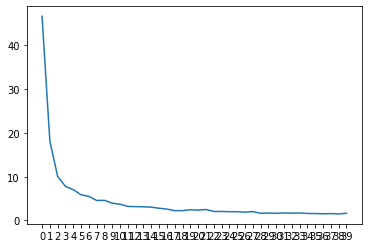

In [24]:
# Fill the hyperparameters with proper values
epochs=40
batch_size=4
learning_rate=0.0001 
save_freq=3
data_dir='data/KingsCollege/'

train(epochs, batch_size, learning_rate, save_freq, data_dir)


## Step 2: Testing

In [25]:
def get_accuracy(pred_xyz, pred_wpqr, poses_gt):
    pose_xyz = poses_gt[0:3]
    pose_wpqr = poses_gt[3:]

    # Calculate position and rotation error
    q1 = pose_wpqr / np.linalg.norm(pose_wpqr)
    q2 = pred_wpqr / np.linalg.norm(pred_wpqr)
    d = abs(np.sum(np.multiply(q1, q2)))
    theta = 2 * np.arccos(d) * 180 / np.pi
    error_x = np.linalg.norm(pose_xyz - pred_xyz)

    return error_x, theta

def test(epoch, data_dir):
    # test dataset and test loader
    datasource = DataSource(data_dir, train=False)
    test_loader = Data.DataLoader(dataset=datasource, batch_size=batch_size, shuffle=True)
    results = np.zeros((len(test_loader.dataset), 2))

    # load model
    posenet = PoseNet(load_weights=False).to(device)

    save_filename = 'epoch_{}.pth'.format(str(epoch).zfill(5))
    save_path = os.path.join('checkpoints', save_filename)
    posenet.load_state_dict(torch.load(save_path))
    print("Checkpoint {} loaded!".format(save_filename))


    with torch.no_grad():
        posenet.eval()
        for step, (images, poses) in enumerate(test_loader):
            b_images = Variable(images).to(device)
            poses[0] = np.array(poses[0])
            poses[1] = np.array(poses[1])
            poses[2] = np.array(poses[2])
            poses[3] = np.array(poses[3])
            poses[4] = np.array(poses[4])
            poses[5] = np.array(poses[5])
            poses[6] = np.array(poses[6])
            poses = np.transpose(poses)
            b_poses = Variable(torch.Tensor(poses)).to(device)

            p_xyz, p_wpqr = posenet(b_images)

            p_xyz_np = p_xyz.cpu().numpy()
            p_wpqr_np = p_wpqr.cpu().numpy()

            for i in range(b_poses.shape[0]):
                print("{}".format(step*batch_size+i))
                print("GT\t| xyz: {}\twpqr: {}".format(poses[i,:3] * 100, poses[i, 3:]))
                print("PRED\t| xyz: {}\twpqr: {}".format(p_xyz_np[i] * 100, p_wpqr_np[i]))

                pos_error, ori_error = get_accuracy(p_xyz_np[i], p_wpqr_np[i], poses[i])
                results[step*batch_size+i, :] = [pos_error, ori_error]
                print("ACC\t| pos: {} m \tori: {} degrees".format(pos_error * 100, ori_error))

        median_result = np.median(results, axis=0)
        mean_result = np.mean(results, axis=0)
        print("-----------------------------")
        print("Median position error: {} m \t Median orientation error: {} degrees".format(median_result[0] * 100, median_result[1]))
        print("Mean position error: {} m \t Mean orientation error: {} degrees".format(mean_result[0] * 100, mean_result[1]))



In [26]:
epochs=40
data_dir='data/KingsCollege/'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

test(epochs, data_dir)

Mean image loaded!
PoseNet model created!
Checkpoint epoch_00040.pth loaded!
0
GT	| xyz: [-19.509803 -17.016859   1.828394]	wpqr: [ 0.680741  0.591615 -0.263813  0.34203 ]
PRED	| xyz: [-12.719756  -16.074661    1.0846074]	wpqr: [ 0.6515498   0.54498285 -0.35298872  0.3976072 ]
ACC	| pos: 6.895338077891186 m 	ori: 13.58293739454127 degrees
1
GT	| xyz: [-31.38189  -15.44122    1.758762]	wpqr: [ 0.624146  0.554662 -0.372114  0.405368]
PRED	| xyz: [-16.533644  -14.554524    1.3866768]	wpqr: [ 0.59528464  0.5455872  -0.38675103  0.4088541 ]
ACC	| pos: 14.87935048996875 m 	ori: 3.4535358797580544 degrees
2
GT	| xyz: [-27.572461 -13.690306   1.494322]	wpqr: [ 0.653788  0.532517 -0.33645   0.41927 ]
PRED	| xyz: [-15.928978   -15.4135065    0.96281207]	wpqr: [ 0.6459121   0.5158555  -0.36525586  0.42222312]
ACC	| pos: 11.782301340400078 m 	ori: 3.9278434123167623 degrees
3
GT	| xyz: [ 95.31596  -43.556121   0.429182]	wpqr: [ 0.62343   0.587391  0.31339  -0.409992]
PRED	| xyz: [ 53.219814  -30.6